Here we explain how to run HMC on the CAL.

In [36]:
import os

import time

import numpy as np

import networkx as nx

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

In [37]:
import matplotlib.pyplot as plt

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 16  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 16  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 24  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 17  # Font size of titlea


In [38]:
os.chdir("Scripts/")
%run -i model.py
os.chdir("../")

In [39]:
N = 100

covariates = tf.expand_dims(tfp.distributions.Normal(loc = 0.0, scale = 1).sample(N), axis = -1)

In [43]:
SIS = logistic_SIS(covariates)

parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
	      "log_beta":tf.math.log(tf.convert_to_tensor([0.2], dtype = tf.float32)),
              "b_I":tf.convert_to_tensor([+0.3], dtype = tf.float32),
              "b_S":tf.convert_to_tensor([-0.3], dtype = tf.float32),
	      "log_gamma":tf.math.log(tf.convert_to_tensor([0.1], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([+0.2], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),}

In [44]:
T    = 200
X, Y = simulator(SIS, parameters, T)

X, Y = X[:,0,...], Y[:,0,...]

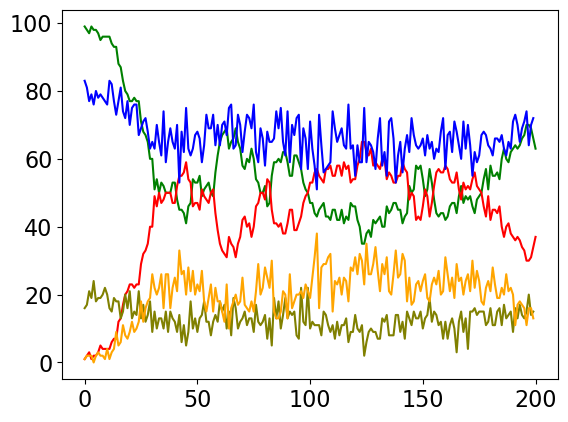

In [45]:
plt.plot(tf.reduce_sum(X, axis = 1 )[:,0], color = "green")
plt.plot(tf.reduce_sum(X, axis = 1 )[:,1], color = "red")

plt.plot(tf.reduce_sum(Y, axis = 1 )[:,0], color = "blue")
plt.plot(tf.reduce_sum(Y, axis = 1 )[:,1], color = "olive")
plt.plot(tf.reduce_sum(Y, axis = 1 )[:,2], color = "orange")

In [46]:
os.chdir("Scripts/")
%run -i CAL.py
%run -i CAL_without_correction.py
os.chdir("../")

In [47]:
start = time.time()
Pi, Mu, log_likelihood = CAL(SIS, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood.numpy())

The time lap is  0.7700772285461426
The log-likelihood is  -15799.142


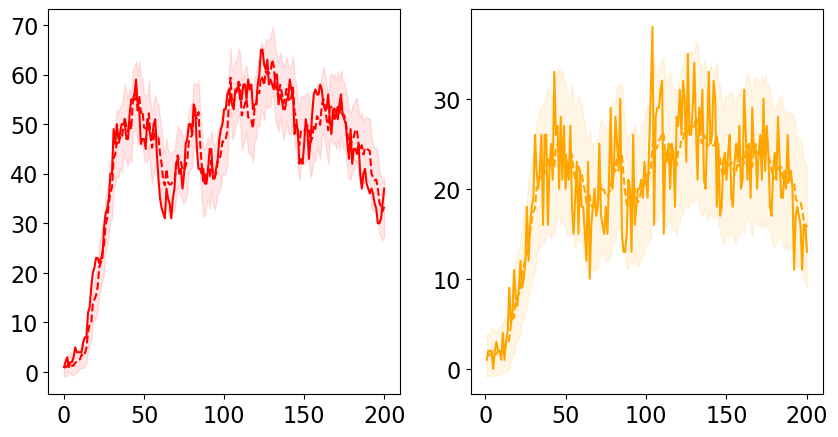

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0].plot(time_steps, population[...,1], color = "red")
ax[0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

Commented code explains how to initialize the HMC with a warm start.

In [50]:
tfd = tfp.distributions

loss_list = []
parameters_list = []

for i in range(5):

	parameters_vector_HMC = tf.convert_to_tensor([np.log(0.1), 0.0, 0.0, np.log(0.1), 0.0, logit(0.1), logit(0.1)], dtype = tf.float32) # this is not used though (just for the shape)
	parameters_vector_HMC = tfd.Normal(loc = 0.0, scale = 1.0).sample(sample_shape= tf.shape(parameters_vector_HMC))

	parameters_HMC = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
		"log_beta":parameters_vector_HMC[0:1],
		"b_I":parameters_vector_HMC[1:2],
		"b_S":parameters_vector_HMC[2:3],
		"log_gamma":parameters_vector_HMC[3:4],
		"b_R":parameters_vector_HMC[4:5],
		"logit_sensitivity": tf.convert_to_tensor([logit(0.9)], dtype = tf.float32), #parameters_vector_HMC[5:6],
		"logit_specificity": tf.convert_to_tensor([logit(0.95)], dtype = tf.float32), #parameters_vector_HMC[6:7],
		"logit_prob_testing":parameters_vector_HMC[5:7],}
	
	try_index = 0
	while (tf.math.is_nan(CAL_loss(SIS, parameters_HMC, Y)) or CAL_loss(SIS, parameters_HMC, Y)>10*T) and try_index<10:

		parameters_vector_HMC = tfd.Normal(loc = 0.0, scale = 1.0).sample(sample_shape= tf.shape(parameters_vector_HMC))

		parameters_HMC = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
			"log_beta":parameters_vector_HMC[0:1],
			"b_I":parameters_vector_HMC[1:2],
			"b_S":parameters_vector_HMC[2:3],
			"log_gamma":parameters_vector_HMC[3:4],
			"b_R":parameters_vector_HMC[4:5],
			"logit_sensitivity": tf.convert_to_tensor([logit(0.9)], dtype = tf.float32), #parameters_vector_HMC[5:6],
			"logit_specificity": tf.convert_to_tensor([logit(0.95)], dtype = tf.float32), #parameters_vector_HMC[6:7],
			"logit_prob_testing":parameters_vector_HMC[5:7],}
		
		try_index = try_index + 1

	n_gradient_steps = 100
	learning_parameters = {"log_beta":1, "b_I":1, "b_S":1, 
			"log_gamma":1,"b_R":1, 
			"logit_prob_testing":2, }

	optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

	loss_tensor, parameters_tensor = CAL_inference(SIS, parameters_HMC, Y, learning_parameters, optimizer, n_gradient_steps, initialization = "parameters")

	loss_list.append(loss_tensor)
	parameters_list.append(parameters_tensor)

2025-02-27 17:51:13.441630: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4b181ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-27 17:51:13.441663: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-02-27 17:51:13.607805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-27 17:51:14.030854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 17:51:14.807454: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


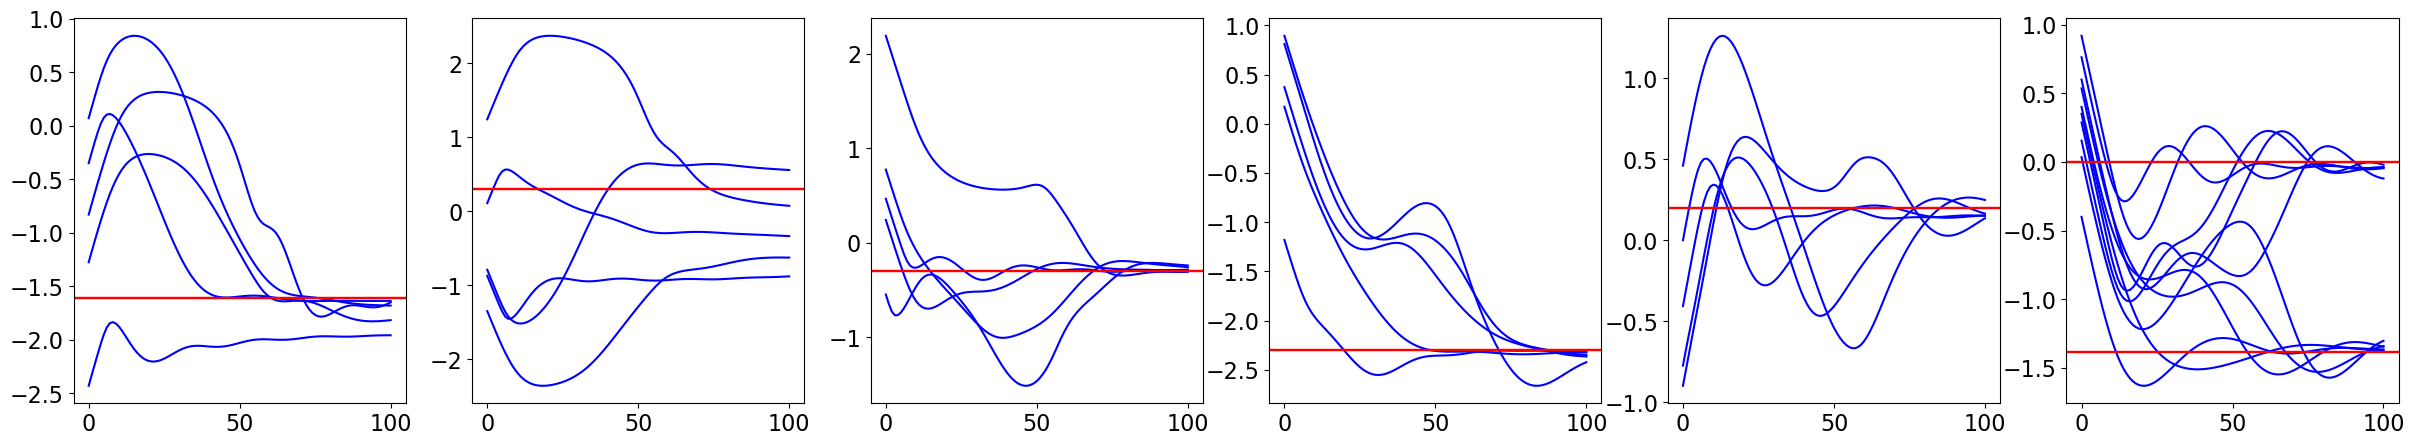

In [66]:
fig, ax = plt.subplots(1, 6, figsize = (30, 5))

for i in range(5):
	k = 0
	for key in parameters_list[i].keys():

		if tf.shape(parameters[key])==1:
			ax[k].plot(parameters_list[i][key], color = "blue")
			ax[k].axhline(parameters[key], color = "red")

			# if k==1:
			# 	ax[k].plot(-parameters_tensor[key], color = "green")

		else:
			for j in range(tf.shape(parameters[key])[0]):
				ax[k].plot(parameters_list[i][key][:,j], color = "blue")
				ax[k].axhline(parameters[key][j], color = "red")

		k = k+1


In [67]:
loss_stack = tf.stack(loss_list, axis = 0)[:,-1]
best_index = tf.math.argmin(tf.where(tf.math.is_nan(loss_stack), 10000*tf.ones(tf.shape(loss_stack)), loss_stack))

parameters_tensor = parameters_list[best_index]

parameters_vector_HMC = tf.convert_to_tensor([parameters_tensor["log_beta"][-1,0],
                                              parameters_tensor["b_I"][-1,0], parameters_tensor["b_S"][-1,0],
                               		      parameters_tensor["log_gamma"][-1,0], parameters_tensor["b_R"][-1,0],
					      parameters_tensor["logit_prob_testing"][-1,0], parameters_tensor["logit_prob_testing"][-1,1]], dtype = tf.float32)

For the HMC reduce the nr of leap frog steps and do not do any adaption

In [68]:
parameter_dim = tf.shape(parameters_vector_HMC)[0]

def prior_fn():
    
    return tfd.MultivariateNormalDiag(loc=tf.zeros([parameter_dim]), scale_diag=100*tf.ones([parameter_dim]))

def log_likelihood_fn(parameters_vector_HMC):

	parameters_HMC = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
		"log_beta":parameters_vector_HMC[0:1],
		"b_I":parameters_vector_HMC[1:2],
		"b_S":parameters_vector_HMC[2:3],
		"log_gamma":parameters_vector_HMC[3:4],
		"b_R":parameters_vector_HMC[4:5],
		"logit_sensitivity": tf.convert_to_tensor([logit(0.9)], dtype = tf.float32), #parameters_vector_HMC[5:6],
		"logit_specificity": tf.convert_to_tensor([logit(0.95)], dtype = tf.float32), #parameters_vector_HMC[6:7],
		"logit_prob_testing":parameters_vector_HMC[5:7],}

	_, _, log_likelihood = CAL(SIS, parameters_HMC, Y)

	return log_likelihood

def joint_log_prob_fn(parameters_vector_HMC):
    
    prior = prior_fn().log_prob(parameters_vector_HMC)
    likelihood = log_likelihood_fn(parameters_vector_HMC)
    
    return prior + likelihood

@tf.function(jit_compile=True)
def run_hmc(initial_state, adaptive_step_size, seed_to_use = None):
    
    # Create the HMC kernel
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=joint_log_prob_fn,
        step_size=adaptive_step_size,
        num_leapfrog_steps=2)
    
    # Run the MCMC chain
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=1000,  # Number of posterior samples
        num_burnin_steps=0,  # Burn-in steps
        current_state=initial_state,
        kernel=hmc_kernel,
	seed = seed_to_use,
        trace_fn=lambda _, pkr: pkr)  # Trace kernel results for diagnostics
    
    return samples, kernel_results

adaptive_step_size = 0.01

samples, kernel_results = run_hmc(parameters_vector_HMC, adaptive_step_size, 123)

posterior_samples = samples.numpy()

2025-02-27 17:57:20.025671: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:104] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed


Still far from convergence but getting there

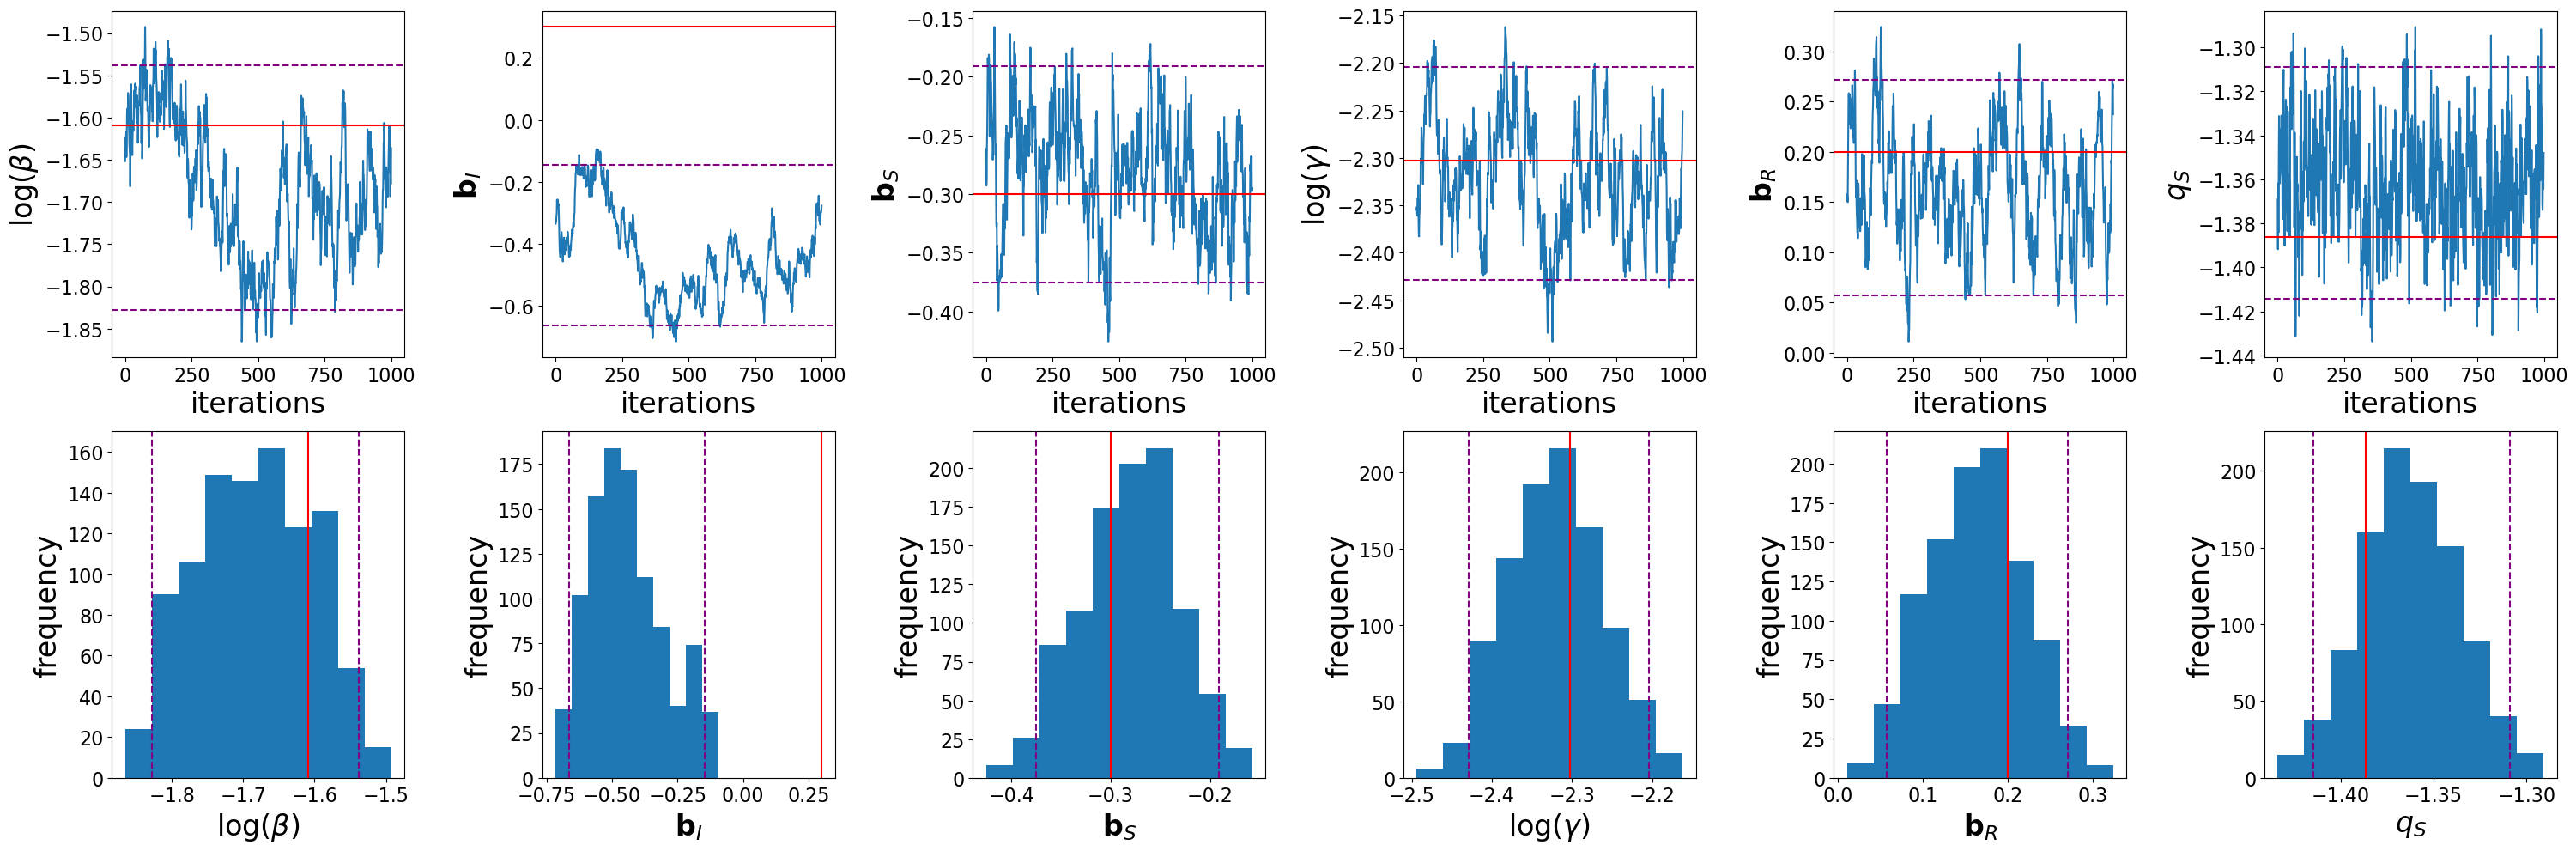

In [70]:
parameters_vector_HMC_true = tf.convert_to_tensor([np.log(0.2), 0.3, -0.3, np.log(0.1), 0.2, logit(0.2), logit(0.5)], dtype = tf.float32)

names_list =  [r"$\log(\beta)$", r"$\mathbf{b}_I$", r"$\mathbf{b}_S$", r"$\log(\gamma)$", r"$\mathbf{b}_R$",
	       r"$q_S$", r"$q_I$"]
 
fig, ax = plt.subplots(2, 6, figsize = (30, 10))

for k in range(6):

	quantiles = np.quantile(posterior_samples[:,k], [0.025, 0.975])

	ax[0,k].set_xlabel("iterations")
	ax[0,k].set_ylabel(names_list[k])
	ax[0,k].plot(posterior_samples[:,k])
	ax[0,k].axhline(parameters_vector_HMC_true[k], color = "red")
	ax[0,k].axhline(quantiles[0], color = "purple", linestyle = "--")
	ax[0,k].axhline(quantiles[1], color = "purple", linestyle = "--")

	ax[1,k].set_xlabel(names_list[k])
	ax[1,k].set_ylabel("frequency")
	ax[1,k].hist(posterior_samples[:,k])
	ax[1,k].axvline(parameters_vector_HMC_true[k], color = "red")
	ax[1,k].axvline(quantiles[0], color = "purple", linestyle = "--")
	ax[1,k].axvline(quantiles[1], color = "purple", linestyle = "--")

plt.subplots_adjust( wspace=0.4)
plt.tight_layout()